# Steigenberger [2012]

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from sympy import Function, Symbol, Eq, solve, dsolve, Derivative, Matrix, Transpose
from sympy import *
from sympy.vector import *

[Sketch](Overview and Biomimetic.png)

We are going to use Euler-Bernoulli beam theory for small/linear and large/nonlinear deflection.
This theory is resticted by:
- The length of the beam must be much larger than its diameter;
- 2D displacement and deformation
- quastistatic conditions

For the whisker we assume:
- straight
- cylindrical
- linear elastic, homogenous material
- one-sided clamped
- load at the tip (direction preserving)

## Definition of variables and functions

with the variables: 
- $x$ as position along the beam [m]
- $E$ as Young's modulus [N/m$^2$]
- $I_z$ as second moment of area [m$^4$]
- $F$ as load / force [N]
- $L$ as length of the beam [m]

and the functions:
- $M(x)$ as bending moment along the beam longitudinal axis [Nm]
- $v(x)$ Elastica [m]
- $\kappa(x)$ curvature [1/m]


In [337]:
x, E, Iz, F, L = sym.symbols('x, E, Iz, F, L',real = 'True')
kappa = Function('kappa')(x)
M = Function('M')
v = Function('v')

Starting with the constitutive equation:

In [338]:
eq1 = Eq(kappa,M(x)/(E*Iz))
eq1

Eq(kappa(x), M(x)/(E*Iz))

In [339]:
sol = solve(eq1, kappa)
kappa = sol[0] # assign kappa(x)

Curvature of a curve in the plane and combining it with the constitutive equation to Euler-Bernoulli beam equation:

In [340]:
eq2 = Eq(diff(v(x),x,x) / (1+(diff(v(x),x))**2)**(3/2), kappa)
eq2

Eq((Derivative(v(x), x)**2 + 1)**(-1.5)*Derivative(v(x), (x, 2)), M(x)/(E*Iz))

## Linear Case

Assumption of small deflection $v'(x) << small$:

In [341]:
eq2_lin = eq2.subs((diff(v(x),x))**2,0)
eq2_lin

Eq(Derivative(v(x), (x, 2)), M(x)/(E*Iz))

Solving the linear ordinary differential equation of second orden and with constant coefficients:

In [342]:
sol = dsolve(eq2_lin.subs(M(x),-F*(L-x)), ics={v(0):0, diff(v(x),x).subs(x,0):0})
sol

Eq(v(x), x*(-F*L*x/2 + F*x**2/6)/(E*Iz))

Assigning values to the varables

In [343]:
F_val = 0.1
L_val = 0.1
E_val = 2.1E11
Iz_val = np.pi/64*1E-3**4
sol = sol.subs([(F, F_val), (L, L_val), (E, E_val), (Iz, Iz_val)])


Make a numpy-ready function from the sympy results:

In [344]:
vx = lambdify(x, sol.rhs,'numpy')
x_vals = np.arange(0,L_val+0.1,0.1)
y_vals = vx(x_vals)

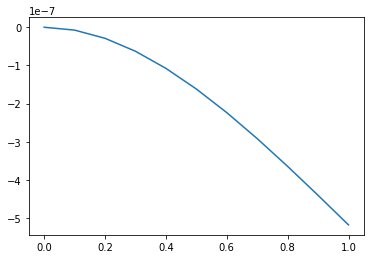

In [345]:
plt.plot(x_vals,y_vals)

## Nonlinear case

Re-formulating the Euler-Bernoulli beam equation:

In [438]:
eq2

Eq((Derivative(v(x), x)**2 + 1)**(-1.5)*Derivative(v(x), (x, 2)), M(x)/(E*Iz))

Switching over to a parametric representation of a curve in a plane:

In [439]:
s, E, Iz, L = sym.symbols('s, E, Iz, L')
x = Function('x')
y = Function('y')
M = Function('M')
varphi = Function('varphi')
kappa = Function('kappa')

In [440]:
eq_x = Eq(diff(x(s),s),cos(varphi(s)))
eq_x

Eq(Derivative(x(s), s), cos(varphi(s)))

In [441]:
eq_y = Eq(diff(y(s),s),sin(varphi(s)))
eq_y

Eq(Derivative(y(s), s), sin(varphi(s)))

In [442]:
eq_phi = Eq(diff(varphi(s),s),kappa(s))
eq_phi

Eq(Derivative(varphi(s), s), kappa(s))

In [443]:
eq_kappa = Eq(kappa(s),M(s)/(E*Iz))
eq_kappa

Eq(kappa(s), M(s)/(E*Iz))

This four equations forms a nonlinear differential equation system.
A description for $M(s)$ is still missing.

Defining $\vec{F}$:

In [445]:
F_vec = Matrix([[0, -F, 0]])
F_vec

Matrix([[0, -F, 0]])

and defining $\vec{r}$:

In [446]:
r_vec = Matrix([[x(L)-x(s), 0, 0]])
r_vec

Matrix([[x(L) - x(s), 0, 0]])

Calculating the cross-product $\vec{r}$ x $\vec{F}$ and selecting the component in $z$-direction:

In [447]:
M_vec = r_vec.cross(F_vec)
M_z = M_vec[2]
M_z

-F*(x(L) - x(s))

Putting $M_z$ in the constitutive equation:

In [448]:
eq_kappa = eq_kappa.subs(M(s),M_z)
eq_kappa

Eq(kappa(s), -F*(x(L) - x(s))/(E*Iz))

Putting $\kappa(s)$ in the ODE sys:

In [450]:
eq_phi = eq_phi.subs(kappa(s),eq_kappa.rhs)
display(eq_x, eq_y, eq_phi)

Eq(Derivative(x(s), s), cos(varphi(s)))

Eq(Derivative(y(s), s), sin(varphi(s)))

Eq(Derivative(varphi(s), s), -F*(x(L) - x(s))/(E*Iz))

What is the problem with this ODE sys?

Boundary conditions:
\begin{align*}
x(0) = 0 &\qquad &x(L) = ?\\
y(0) = 0 &\qquad &y(L) = ?\\
\varphi(0) = 0 &\qquad & \varphi(L) = ?
\end{align*}

We do not know at the beginning $x(L)$ but is is necessary ... so we have to guess something. 
- shooting method
- optimization
- switch over to normal python ...